In [6]:
import os
import cv2
import numpy as np
from pprint import pprint
import json

### Util functions

In [10]:
import matplotlib.pyplot as plt

def show_cv_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.axis('off')


In [11]:
def show_corners(img, corners):
    for corner in corners:
        cv2.circle(img, tuple(map(int, corner)), radius=10, color=(255, 0, 0), thickness=-1)

### Copy imgs

In [11]:
DATA_DIR = 'data/'
DIR_ORG = DATA_DIR + 'v1.0.2/'
DIR_SYN = DATA_DIR + 'synthetic/origin/'

In [12]:
for dir in os.listdir(DIR_SYN):
    print(f"{dir} : {len(os.listdir(DIR_SYN + dir))}")

CitizenCardV1_back : 385
CitizenCardV1_front : 400
CitizenCardV2_back : 340
CitizenCardV2_front : 393
IdentificationCard_back : 384
IdentificationCard_front : 383
LicenseCard : 189
Other : 36
Passport : 10


In [30]:
dirs = os.listdir(DIR_ORG)
dirs

['cccd_v1_back',
 'cccd_v1_front',
 'cccd_v2_back',
 'cccd_v2_front',
 'cmnd_v1_back',
 'cmnd_v1_front']

In [34]:
new_dirs = ['CitizenCardV1_back', 'CitizenCardV1_front', 'CitizenCardV2_back', 'CitizenCardV2_front', 'IdentificationCard_back', 'IdentificationCard_front']

In [40]:
import shutil

for j, dir in enumerate(dirs):
    src_dir = DIR_ORG + dir + '/images/part_1/'
    imgs = list(sorted(os.listdir(src_dir)))

    dst_dir = DIR_SYN + new_dirs[j] + '/'
    os.makedirs(dst_dir, exist_ok=True)
    
    i = 0
    while i < len(imgs):
        img_name = imgs[i].split('.')[0]
        img_name = '_'.join(p for p in img_name.split('_')[1:-1])
        if img_name.startswith('_'):
            img_name = '_'.join(p for p in img_name.split('_')[1:])
        
        if not os.path.exists(dst_dir + imgs[i]):
            shutil.copy(src_dir + imgs[i], dst_dir + img_name + '.png')
        i += 5

    print(f"{dir} : {len(imgs)} ---> {new_dirs[j]} : {len(os.listdir(dst_dir))}")



cccd_v1_back : 1925 ---> CitizenCardV1_back : 385
cccd_v1_front : 2000 ---> CitizenCardV1_front : 400
cccd_v2_back : 1700 ---> CitizenCardV2_back : 340
cccd_v2_front : 1965 ---> CitizenCardV2_front : 393
cmnd_v1_back : 1920 ---> IdentificationCard_back : 384
cmnd_v1_front : 1915 ---> IdentificationCard_front : 383


### Create original data for `LicenceCard`, `Other`, `Passport` classes

In [69]:
DATA_DIR = 'data/'

DIR_SRC = DATA_DIR + 'clfn/'
DIR_DST = DATA_DIR + 'synthetic/origin/'

In [114]:
anno_dir = DIR_SRC + 'annos/'
img_dir = DIR_SRC + 'images/'


for dir in os.listdir(img_dir):
    # Read anno file
    anno = json.load(open(anno_dir + dir + '.json'))

    if len(anno['images']) != len(anno['annotations']):
        print(f"Diffenct size: {len(anno['images'])} images with {len(anno['annotations'])} annos for [{dir}]")
        continue

    for i in range(len(anno['images'])):
        # Take image file

        img_file = anno['images'][i]['file_name']
        img_path = img_dir + dir + '/' + img_file

        if os.path.exists(img_path):
            # Load image
            img = cv2.imread(img_path)

            # Take coordinates of segmentation points
            coords = anno['annotations'][i]['segmentation'][0]
            points = []
            for i in range(len(coords)):
                if i % 2 == 0:
                    points.append(tuple(map(int, (coords[i], coords[i+1]))))

            # Convert to numpy array
            pts = np.array([np.array(i) for i in points])

            # Get 4 corners
            s = pts.sum(axis=1)
            tl = pts[np.argmin(s)]
            br = pts[np.argmax(s)]

            diff = np.diff(pts, axis=1)
            tr = pts[np.argmin(diff)]
            bl = pts[np.argmax(diff)]
            
            corners = [tl, tr, br, bl]

            # Define source points on original image
            src = np.array(corners, dtype='float32')

            # Get the shape of new image
            mins = np.min(pts, axis=0)
            x_min, y_min = map(int, (mins[0], mins[1]))
            maxs = np.max(pts, axis=0)
            x_max, y_max = map(int, (maxs[0], maxs[1]))

            new_w = x_max - x_min
            new_h = y_max - y_min

            # Define destination points on new image
            dst = np.array([
                [0, 0],
                [new_w - 1, 0],
                [new_w - 1, new_h - 1],
                [0, new_h]],
                dtype='float32')

            # Perform 'reversed' perspective transform
            trans_mat = cv2.getPerspectiveTransform(src, dst)
            warp = cv2.warpPerspective(img, trans_mat, (new_w, new_h))

            dst_dir = DIR_DST + dir + '/'
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            cv2.imwrite(dst_dir + img_file, warp)

        else:
            print(f"Missing image [{img_file}]")


### Background

In [62]:
DATA_DIR = 'data/'
DIR_SRC = DATA_DIR + 'background/'
DIR_DST = DATA_DIR + 'synthetic/resized_bg/'
if not os.path.exists(DIR_DST):
    os.mkdir(DIR_DST)

In [65]:
for bg in os.listdir(DIR_SRC):
    img = cv2.imread(DIR_SRC + bg)
    resized = cv2.resize(img, (1024, 1024))
    
    print(f"{bg} : {img.shape}")
    resized_path = DIR_DST + 'resized_' + bg.split('.')[0] + '.png'
    if not os.path.exists(resized_path):
        cv2.imwrite(resized_path, resized)

bg_0.jpeg : (1024, 1365, 3)
bg_1.png : (1024, 1365, 3)
bg_2.jpg : (1024, 1024, 3)
bg_3.jpg : (523, 640, 3)
bg_4.jpg : (631, 950, 3)
bg_5.png : (376, 550, 3)
bg_6.jpg : (1280, 1440, 3)
bg_7.png : (866, 1300, 3)
bg_8.png : (866, 1300, 3)
bg_9.jpg : (1280, 1280, 3)


### Data Synthesis

In [14]:
DATA_DIR = 'data/synthetic/'
DIR_BG = DATA_DIR + 'resized_bg/'
DIR_ORG = DATA_DIR + 'origin/'
DIR_SYN = DATA_DIR + 'synthesis/'

for s in ['images/', 'masks']:
    if not os.path.exists(DIR_SYN + s):
        os.mkdir(DIR_SYN + s)

In [3]:
dirs = list(sorted(os.listdir(DIR_ORG)))
dirs

['CitizenCardV1_back',
 'CitizenCardV1_front',
 'CitizenCardV2_back',
 'CitizenCardV2_front',
 'IdentificationCard_back',
 'IdentificationCard_front',
 'LicenseCard',
 'Other',
 'Passport']

In [4]:
def get_params(width: int, height: int, distortion_scale: float):
    """Get parameters for ``perspective`` for a random perspective transform.

    Args:
        width (int): width of the image.
        height (int): height of the image.
        distortion_scale (float): argument to control the degree of distortion and ranges from 0 to 1.

    Returns:
        List containing [top-left, top-right, bottom-right, bottom-left] of the original image,
        List containing [top-left, top-right, bottom-right, bottom-left] of the transformed image.
    """
    half_height = height // 2
    half_width = width // 2
    topleft = np.array([
        int(np.random.randint(0, int(distortion_scale * half_width) + 1, size=(1,))),
        int(np.random.randint(0, int(distortion_scale * half_height) + 1, size=(1,))),
    ])
    topright = np.array([
        int(np.random.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,))),
        int(np.random.randint(0, int(distortion_scale * half_height) + 1, size=(1,))),
    ])
    botright = np.array([
        int(np.random.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,))),
        int(np.random.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,))),
    ])
    botleft = np.array([
        int(np.random.randint(0, int(distortion_scale * half_width) + 1, size=(1,))),
        int(np.random.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,))),
    ])
    startpoints = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')
    endpoints = np.array([topleft, topright, botright, botleft], dtype='float32')
    return startpoints, endpoints

(480, 746, 3)
[[ 17.  19.]
 [729.  21.]
 [705. 456.]
 [ 26. 469.]]
(480, 746, 3) (450, 712, 3)
[[17 19]]
[[  0.   0.]
 [712.   2.]
 [688. 437.]
 [  9. 450.]]
48 71
[[544 619]]
[[ 48.  71.]
 [760.  73.]
 [736. 508.]
 [ 57. 521.]]


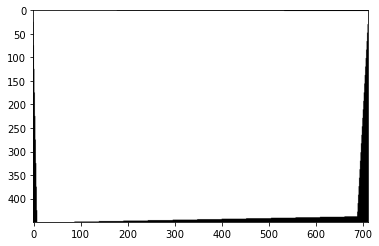

In [17]:

for dir in dirs:
    img = cv2.imread(src_dir + img_name)

    # show_cv_img(img)
    print(img.shape)
    

    
    
    
    # for corner in dst:
    #     cv2.circle(warp, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)
    
    print(dst)


    # print(x_min, y_min, x_max, y_max)
    

    print(warp.shape, cut.shape)

    # show_cv_img(warp)

    
    # print(cut.shape)
    # diff = np.array([[height - cut_height, width - cut_width]])
    
    print(diff)
    
    print(dst_cut)
    # for corner in dst_cut:
    #     cv2.circle(cut, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)
    
    
    show_cv_img(mask_cut)


    # print(bg.shape)
    

    # rand_x = np.random.randint(cut_width//2 + 1, bg_width - cut_width//2 - 1)
    # rand_y = np.random.randint(cut_height//2 + 1, bg_height - cut_height//2 - 1)
    # rand_center = (rand_x, rand_y)
    # print(rand_center)
    # cv2.circle(bg, rand_center, radius=10, color=(255, 0, 0), thickness=-1)

    # mask = np.zeros(cut.shape, cut.dtype)
    # cv2.fillPoly(mask, [dst.astype('int32')], (255, 255, 255))
    # clone = cv2.seamlessClone(cut, bg, mask, rand_center, cv2.NORMAL_CLONE)


    print(rand_x, rand_y)
    # cv2.circle(bg, (rand_x, rand_y), radius=10, color=(255, 0, 0), thickness=-1)      

    # bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width] = cut
    # show_cv_img(bg)
    # cv2.imwrite(DIR_SYN + 'test.png', bg)

    rand_start = np.array([[rand_x, rand_y]])
    diff = np.array([[bg_height - height, bg_width - width]], dtype='int32')
    print(diff)

    corners = rand_start + dst_cut # - diff
    print(corners)
    # for corner in corners:
    #     cv2.circle(bg, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)




In [5]:
avg_w, avg_h, avg_ratio = 0, 0, 0
global_avg_w, global_avg_h, global_avg_ratio = 0, 0, 0

for j, dir in enumerate(dirs):
    for i, bg in enumerate(os.listdir(DIR_ORG + dir + '/')):
        img = cv2.imread(DIR_ORG + dir + '/' + bg)

        h, w = img.shape[:2]
        ratio = w / h
        
        avg_w = (avg_w * i + w) / (i + 1)
        avg_h = (avg_h * i + h) / (i + 1)
        avg_ratio = (avg_ratio * i + ratio) / (i + 1)
        # print(f"{bg} : {img.shape}")
    #print(avg)
    global_avg_w = (global_avg_w * j + avg_w) / (j + 1)
    global_avg_h = (global_avg_h * j + avg_h) / (j + 1)
    global_avg_ratio = (global_avg_ratio * j + avg_ratio) / (j + 1)

print(global_avg_w)
print(global_avg_h)
print(global_avg_ratio)

NameError: name 'cv2' is not defined

In [7]:
def resize_obj(img):
    h, w = img.shape[:2]

    new_w = int(w * 540 / h)
    img = cv2.resize(img, (new_w, 540))
    if new_w > 840:
        img = cv2.resize(img, (840, int(540 * 840 / new_w)))
    
    # if h > 540:
    #     new_w = int(w * 540 / h)
    #     img = cv2.resize(img, (new_w, 540))
    #     if new_w > 840:
    #         img = cv2.resize(img, (840, int(540 * 840 / new_w)))
    # if w > 840:
    #     img = cv2.resize(img, (840, int(h * 840 / w)))
    
    ratio = np.random.choice(np.arange(0.5, 1.2, 0.1))
    h, w = img.shape[:2]
    img = cv2.resize(img, (int(ratio * w), int(ratio * h)))
    return img

In [18]:
def transform(img, width, height):
    # Perspective transform
    src, dst = get_params(width, height, distortion_scale=0.15)
    trans_mat = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(img, trans_mat, (width, height))

    mins = np.min(dst, axis=0)
    x_min, y_min = map(int, (mins[0], mins[1]))
    maxs = np.max(dst, axis=0)
    x_max, y_max = map(int, (maxs[0], maxs[1]))

    cut = warp[y_min:y_max, x_min:x_max]
    cut_height, cut_width = cut.shape[:2]

    diff = np.array([[x_min, y_min]])
    dst_cut = dst - diff

    # Random rotate 90 degrees
    p = np.random.choice(3, p=[0.6, 0.2, 0.2])
    if p == 1:
        rt_cut = cv2.rotate(cut, cv2.ROTATE_90_CLOCKWISE)
        tl = np.array([cut_height - dst_cut[3][1], dst_cut[3][0]])
        tr = np.array([cut_height - dst_cut[0][1], dst_cut[0][0]])
        br = np.array([cut_height - dst_cut[1][1], dst_cut[1][0]])
        bl = np.array([cut_height - dst_cut[2][1], dst_cut[2][0]])
        new_dst = np.array([tl ,tr, br, bl])
        return rt_cut, new_dst
    elif p == 2:
        rt_cut = cv2.rotate(cut, cv2.ROTATE_90_COUNTERCLOCKWISE)
        tl = np.array([dst_cut[1][1], cut_width - dst_cut[1][0]])
        tr = np.array([dst_cut[2][1], cut_width - dst_cut[2][0]])
        br = np.array([dst_cut[3][1], cut_width - dst_cut[3][0]])
        bl = np.array([dst_cut[0][1], cut_width - dst_cut[0][0]])
        new_dst = np.array([tl ,tr, br, bl])
        return rt_cut, new_dst
    else:
        return cut, dst_cut

In [9]:
def augment(img_info, rate=1, show_annos=False):
    # Init lists for annotation
    images, annotations = [], []

    org_img = cv2.imread(img_info['path'])
    img = org_img.copy()

    for r in range(rate):
        ## Resize img with random ratio
        img = resize_obj(img)
        height, width = img.shape[:2]
        # if img.shape != resized.shape:
        #     print(f"{img_name} : {img.shape} ---> {resized.shape}")
        #     cv2.imwrite(dst_dir + 'origin.png', img)
        #     cv2.imwrite(dst_dir + 'resized.png', resized)
        #     break
        
        ## Transform img
        cut, dst_cut = transform(img, width, height)
        cut_height, cut_width = cut.shape[:2]

        ## Create mask of object
        mask_cut = np.zeros(cut.shape, dtype='uint8')        
        cv2.drawContours(mask_cut, [dst_cut.reshape((-1, 1, 2)).astype('int32')], -1, (255, 255, 255), -1)

        ## Get random background
        bg_num = np.random.randint(0, 10)
        bg = cv2.imread(DIR_BG + f'resized_bg_{bg_num}.png')
        bg_height, bg_width = bg.shape[:2]
        bg_org = bg.copy()

        ## Create random root point 
        rand_x = np.random.randint(0, bg_width - cut_width - 1)
        rand_y = np.random.randint(0, bg_height - cut_height - 1)
        root_point = (rand_x, rand_y)

        ## Calculate new corners and convert to segmentation for annos
        corners = dst_cut + np.array([[rand_x, rand_y]])
        segment = [[]]
        for corner in corners:
            segment[0].extend(list(corner))

        ## Combine object with random background to create composite image
        fin_cut = cv2.cvtColor(cut, cv2.COLOR_RGB2RGBA)
        blue, green, red, a = cv2.split(fin_cut)
        a = mask_cut
        fin_cut[:, :, 0] = cut[:, :, 0]
        fin_cut[:, :, 1] = cut[:, :, 1]
        fin_cut[:, :, 2] = cut[:, :, 2]
        fin_cut[:, :, 3] = a[:, :, 0]

        alpha_s = fin_cut[:, :, 3] / 255.
        alpha_l = 1. - alpha_s

        for c in range(3):
            bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width, c] = (alpha_s * cut[:, :, c] +
                                alpha_l * bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width, c])

        ## Smooth edges with Gaussian Blur
        mask_bg = np.zeros(bg.shape, dtype='uint8')
        mask_bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width] = mask_cut

        alpha = cv2.GaussianBlur(mask_bg, (15, 15), 50).astype('float32') / 255.

        comp = alpha * bg.astype('float32') + (1 - alpha) * bg_org.astype('float32')

        ## Show annos
        if show_annos:
            # Bounding box
            cv2.rectangle(comp, (rand_x, rand_y), (rand_x+cut_width, rand_y+cut_height), (0, 255, 0))

            # Corners and segmentation mask
            for corner in corners:
                cv2.circle(comp, tuple(map(int, corner)), radius=5, color=(0, 0, 255), thickness=-1)
            # seg = np.zeros(cut.shape, dtype='uint8')
            # cv2.drawContours(comp, [corners.reshape((-1, 1, 2)).astype('int32')], -1, (255, 255, 255), -1)

            # Root point
            cv2.circle(comp, root_point, radius=5, color=(255, 0, 0), thickness=-1)
        
        ## Write composite image & mask image
        # old_name = img_info['name'].split('.')[0]
        # new_name = old_name + f'_{r}.png'
        img_name = f"{img_info['class']}_{img_info['num']}_aug_{r}.png"
        mask_name = f"{img_info['class']}_{img_info['num']}_aug_{r}_mask.png"
        cv2.imwrite(DIR_SYN + 'images/' + img_name, comp)
        cv2.imwrite(DIR_SYN + 'masks/' + mask_name, mask_bg)

        ## Write annos
        image = {
            'id': img_info['start_id'] + r,
            'file_name': img_name,
            'height': comp.shape[0],
            'width': comp.shape[1],
            'mask_name': mask_name
        }

        annotation = {
            'id': img_info['start_id'] + r,
            'image_id': img_info['start_id'] + r,
            'iscrowd': 0,
            'category_id': img_info['cls_id'],
            'bbox': [rand_x * 1., rand_y * 1., cut_width * 1., cut_height * 1.],
            'box': [rand_x * 1., rand_y * 1., (rand_x + cut_width) * 1., (rand_y + cut_height) * 1.],
            'area': cut_width * cut_height * 1.,
            'segmentation': segment
        }

        images.append(image)
        annotations.append(annotation)
    return images, annotations

        

In [19]:
images, annotations = [], []
curr_id = 0

for cls_id, dir in enumerate(dirs):
    src_dir = DIR_ORG + dir + '/'
    dst_dir = DIR_SYN + dir + '/'
    # if not os.path.exists(dst_dir):
    #     os.mkdir(dst_dir)
    
    num_img = len(os.listdir(src_dir))
    rate = 400 // num_img

    for img_num, img_file in enumerate(os.listdir(src_dir)[:5]):
        img_path = src_dir + img_file
        
        img_info = {
            'start_id': curr_id,
            'num': img_num,
            'path': img_path,
            'class': dir,
            'cls_id': cls_id + 1
        }
        
        images_, annotations_ = augment(img_info, rate=rate, show_annos=False)
        images.extend(images_)
        annotations.extend(annotations_)

        curr_id += rate
    
    print(f"{dir} : {num_img * rate}")

        # break
    # break

In [21]:
with open(DIR_SYN + 'annotations.json', 'w+') as f:
    json.dump({
        'info': {
            'description': "eKYC Synthetic Dataset",
            'version': "v1.0",
            'date_created': "07/04/2022",
            'contributor': "phatdp, cuonghv"
        },
        'categories': [
            {'id': 1, 'name': "CitizenCardV1_back"},
            {'id': 2, 'name': "CitizenCardV1_front"},
            {'id': 3, 'name': "CitizenCardV2_back"},
            {'id': 4, 'name': "CitizenCardV2_front"},
            {'id': 5, 'name': "IdentificationCard_back"},
            {'id': 6, 'name': "IdentificationCard_front"},
            {'id': 7, 'name': "LicenseCard"},
            {'id': 8, 'name': "Other"},
            {'id': 9, 'name': "Passport"}
        ],
        'images': images,
        'annotations': annotations
    }, f, indent=4)